#  **1.Introduction**
The CIFAR-10 dataset contains 60,000 color images of 32 x 32 pixels in 3 channels divided into 10 classes. Each class contains 6,000 images. The training set contains 50,000 images, while the test sets provides 10,000 images. This image taken from the CIFAR repository ( https://www.cs.toronto.edu/~kriz/cifar.html ). This is a classification problem with 10 classes(muti-label classification). We can take a view on this image for more comprehension of the dataset.



The challenge is to recognize previously unseen images and assign them to one of the 10 classes.

Ok Let's get started.

# **2. Import and Preprocess the data**

# 2.1 Import all required libraries

In [29]:
from __future__                 import print_function
from keras.datasets             import cifar10
from keras.preprocessing.image  import ImageDataGenerator
from keras.models               import Sequential
from keras.layers               import Dense , Dropout , Flatten
from sklearn.metrics            import confusion_matrix , classification_report

import os
import keras
import numpy                    as np
import seaborn                  as sns
import matplotlib.pyplot        as plt
import itertools
import tensorflow               as tf

%matplotlib inline



Let's setting the models hyperparameters and others global parameters.

In [30]:
batch_size = 128
epochs = 20
num_classes = 10
data_augmentation = False

## 2.2 Import and preprocess the data

In [31]:
# Split the data between train and test
(x_train , y_train) , (x_test , y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


# 2.3 Distribution of Data

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'classes')

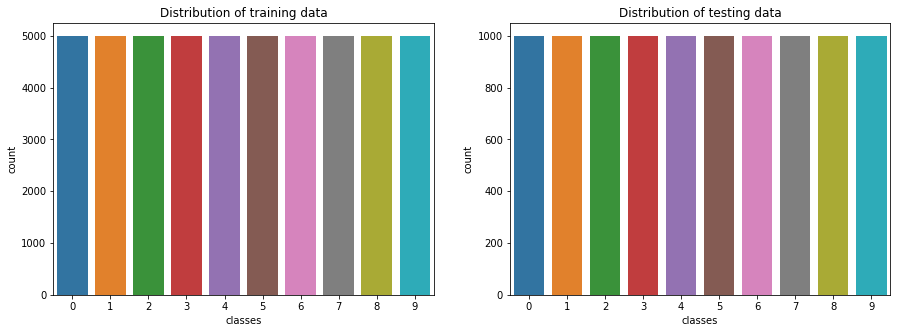

In [32]:
fig , axs = plt.subplots(1,2,figsize =(15,5))
# Count plot for training dataset
sns.countplot(y_train.ravel(),ax=axs[0])
axs[0].set_title("Distribution of training data")
axs[0].set_xlabel("classes")

#count plot for testing dateset
sns.countplot(y_test.ravel(),ax=axs[1])
axs[1].set_title("Distribution of testing data")
axs[1].set_xlabel("classes")


As we can see, each classe contain exacly 6000 examples( 5000 for training and 1000 for test).

The graph above is very important for the training, for example if we had just 1000 samples of label 1 that will be a problem , the model will find difficulties to detect label 1"less accuracy ", so that's not going to happend everything look fine. It's important to know the distribution of dataset behind different classes because the goodness of our model depend on it.

Now let's doing some preprocessing.

The output variable have 10 posible values. This is a multiclass classification problem. We need to encode these lables to one hot vectors (ex : "bird" -> [0,0,1,0,0,0,0,0,0,0]).

In [33]:
# Normalize the data. Before we need to convert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

## **3. Defining the model architecture Using ConVnets**
Now Let us define a suitable deep net.

- In the first stage, Our net will learn 32 convolutional filters, each of which with a 3 x 3 size. The output dimension is the same one of the input shape, so it will be 32 x 32 and activation is relu, which is a simple way of introducing non-linearity; folowed by another 32 convolutional filters, each of which with a 3 x 3 size and activation is also relu. After that we have a max-pooling operation with pool size 2 x 2 and a dropout at 25%.
- In the next stage in the deep pipeline, Our net will learn 64 convolutional filters, each of which with a 3 x 3 size. The output dimension is the same one of the input shape and activation is relu; folowed by another 64 convolutional filters, each of which with a 3 x 3 size and activation is also relu. After that we have a max-pooling operation with pool size 2 x 2 and a dropout at 25%.
- And the Final stage in the deep pipeline is a dense network with 512 units and relu activation followed by a dropout at 50% and by a softmax layer with 10 classes as output, one for each category.

Now let us look at the code review for our architecture.

In [34]:
# Sequential API model object creation
model = Sequential()

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),input_shape=x_train.shape[1:],activation='relu'))
model.add(tf.keras.layers.Conv2D(32, (3, 3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

#CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))


# FLATTERN => DENSE => RELU => DROPOUT
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

#A softmax classifier
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.Activation('softmax'))

# summary of entire model
model.summary()



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)         

# **4. Model training**
Before making network ready for training we have to make sure to add below things:

A loss function: to measure how good the network is
An optimizer: to update network as it sees more data and reduce loss value
Metrics: to monitor performance of network
Also note that for data augmentation:

One of the most commun tehnique to avoid overfitting is data augmentation. And We know that overfitting is generaly occur when we don't have enought data for training the model. To avoid this overfitting problem, we need to expand artificially our dataset. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

Different data aumentation techniques are as follows: Cropping, Rotating, Scaling, Translating, Flipping, Adding Gaussian noise to input images, etc...

In [35]:
#Initiate the optimizer
opt = keras.optimizers.RMSprop(learning_rate = 0.001 , decay = 1e-6)

#Lets train the model using RMS prop
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy')

In [36]:
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

Not using data augmentation.
Epoch 1/20
391/391 [==============================] - 3s 9ms/step - loss: 1.7998 - accuracy: 0.3468 - val_loss: 1.4451 - val_accuracy: 0.4894
Epoch 2/20
391/391 [==============================] - 3s 8ms/step - loss: 1.3856 - accuracy: 0.5065 - val_loss: 1.5100 - val_accuracy: 0.4964
Epoch 3/20
391/391 [==============================] - 3s 8ms/step - loss: 1.1830 - accuracy: 0.5826 - val_loss: 1.0310 - val_accuracy: 0.6359
Epoch 4/20
391/391 [==============================] - 3s 8ms/step - loss: 1.0556 - accuracy: 0.6322 - val_loss: 1.0102 - val_accuracy: 0.6523
Epoch 5/20
391/391 [==============================] - 3s 8ms/step - loss: 0.9617 - accuracy: 0.6641 - val_loss: 0.9367 - val_accuracy: 0.6705
Epoch 6/20
391/391 [==============================] - 3s 9ms/step - loss: 0.8886 - accuracy: 0.6902 - val_loss: 0.8341 - val_accuracy: 0.7079
Epoch 7/20
391/391 [==============================] - 3s 8ms/step - loss: 0.8334 - accuracy: 0.7104 - val_loss: 0.7882 

# **5. Evaluate the model**

## 5.1 Training and validation curves.
Let's see the training and validation process by the visualization of history of fitting. This allow us to quickly know if how our model fit our data (overfitting, underfitting, model convergence, etc...)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


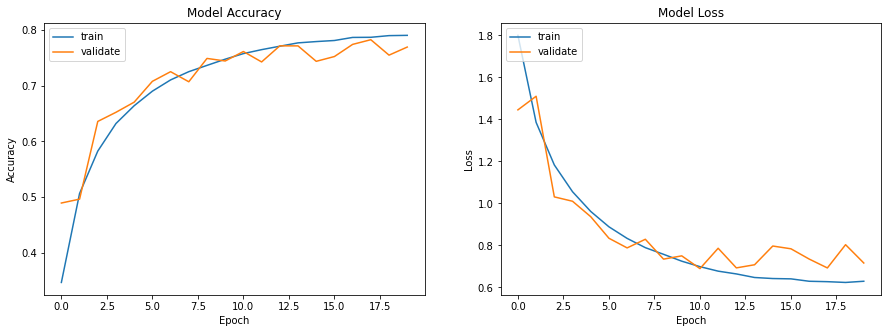

In [37]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

    
# list all data in history
print(history.history.keys())

plotmodelhistory(history)

As we can see, after 18 epochs, the accuracy of our model doesn't really increase. But our model doesn't overffit.


## 5.2 Score trained model and prediction.

In [39]:
score = model.evaluate(x_test,y_test,)
print("test loss : ",score[0])
print("test accuracy : ",score[1])


# make prediction.
pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7163 - accuracy: 0.7694
test loss :  0.7162697315216064
test accuracy :  0.7694000005722046


Now Let's investigate for errors.

# 5.3 Confusion matrix.
Confusion matrix can be very helpfull to see your model drawbacks. We plot the confusion matrix of the validation results. For good vizualization of our confusion matrix, we have to define to fonction.

In [40]:

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

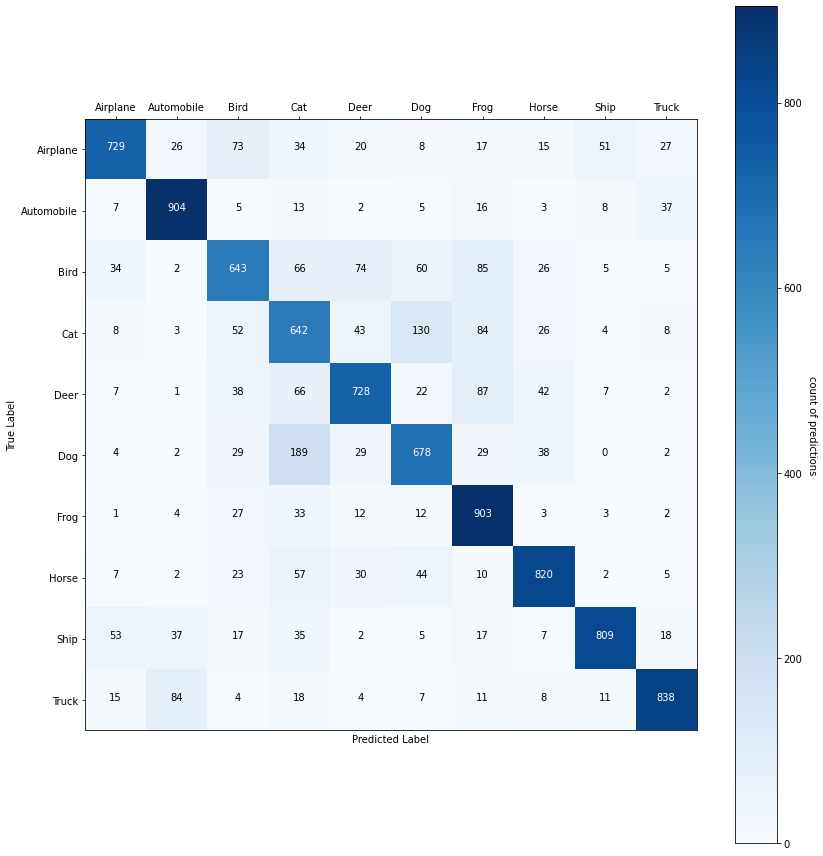

In [41]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [42]:
print(classification_report(Y_true,Y_pred_classes))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1000
           1       0.85      0.90      0.88      1000
           2       0.71      0.64      0.67      1000
           3       0.56      0.64      0.60      1000
           4       0.77      0.73      0.75      1000
           5       0.70      0.68      0.69      1000
           6       0.72      0.90      0.80      1000
           7       0.83      0.82      0.82      1000
           8       0.90      0.81      0.85      1000
           9       0.89      0.84      0.86      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



Chech the prediction

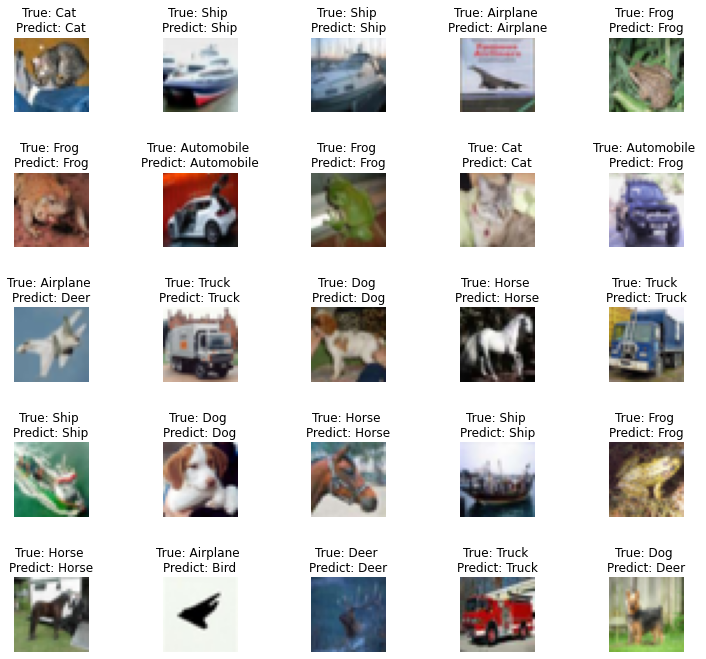

In [43]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

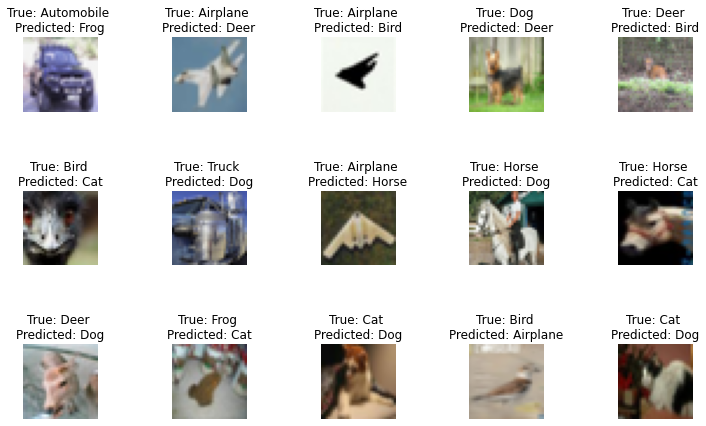

In [44]:
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

- Testing the model with the test images in the test set.
Now we can play with our model for some fun.

In [45]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    test_result = model.predict_classes(test_image)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

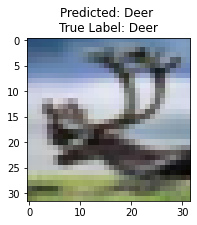

In [49]:
show_test(40)

In [50]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 
313/313 [==============================] - 1s 3ms/step - loss: 0.7163 - accuracy: 0.7694
Test loss: 0.7162697315216064
Test accuracy: 0.7694000005722046
